
Running Simulation for Option 1: Trigonometric and Exponential Terms

Replication 10/30 completed.
Replication 20/30 completed.
Replication 30/30 completed.


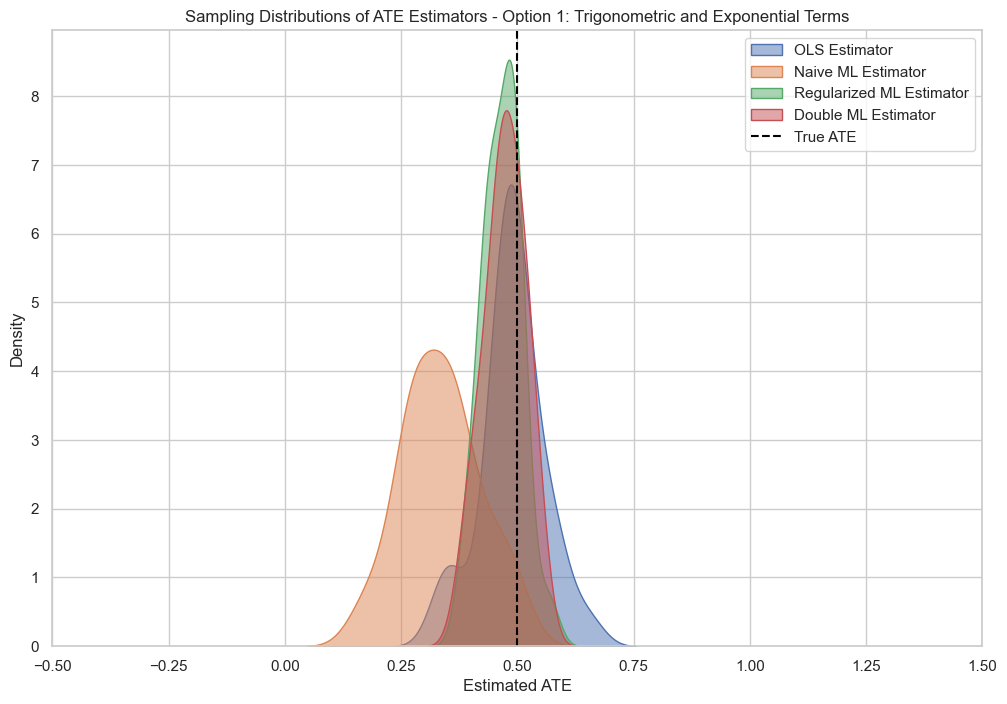


Summary Statistics:
               mean       std      Bias
OLS        0.489113  0.067480 -0.010887
Naive_ML   0.334702  0.082673 -0.165298
Reg_ML     0.465591  0.041630 -0.034409
Double_ML  0.472177  0.045054 -0.027823



Running Simulation for Option 2: Sparse Interactions with Polynomial Growth

Replication 10/30 completed.
Replication 20/30 completed.
Replication 30/30 completed.


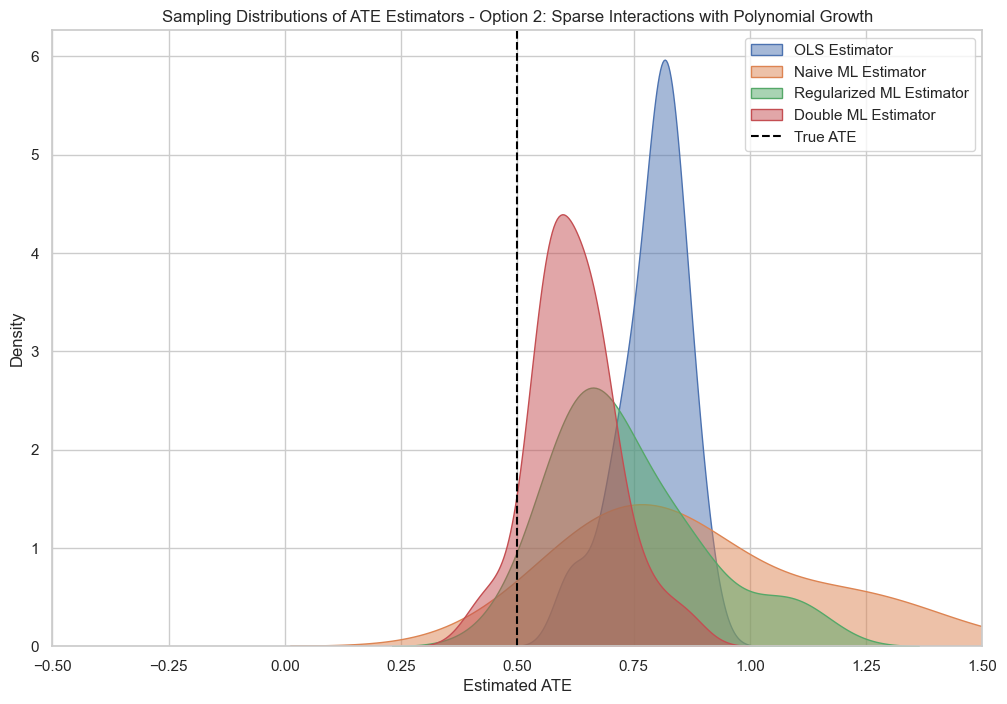


Summary Statistics:
               mean       std      Bias
OLS        0.790424  0.071165  0.290424
Naive_ML   0.903879  0.302475  0.403879
Reg_ML     0.735162  0.159783  0.235162
Double_ML  0.621393  0.090139  0.121393



Running Simulation for Option 3: Noisy Signal with Latent Periodicity

Replication 10/30 completed.
Replication 20/30 completed.
Replication 30/30 completed.


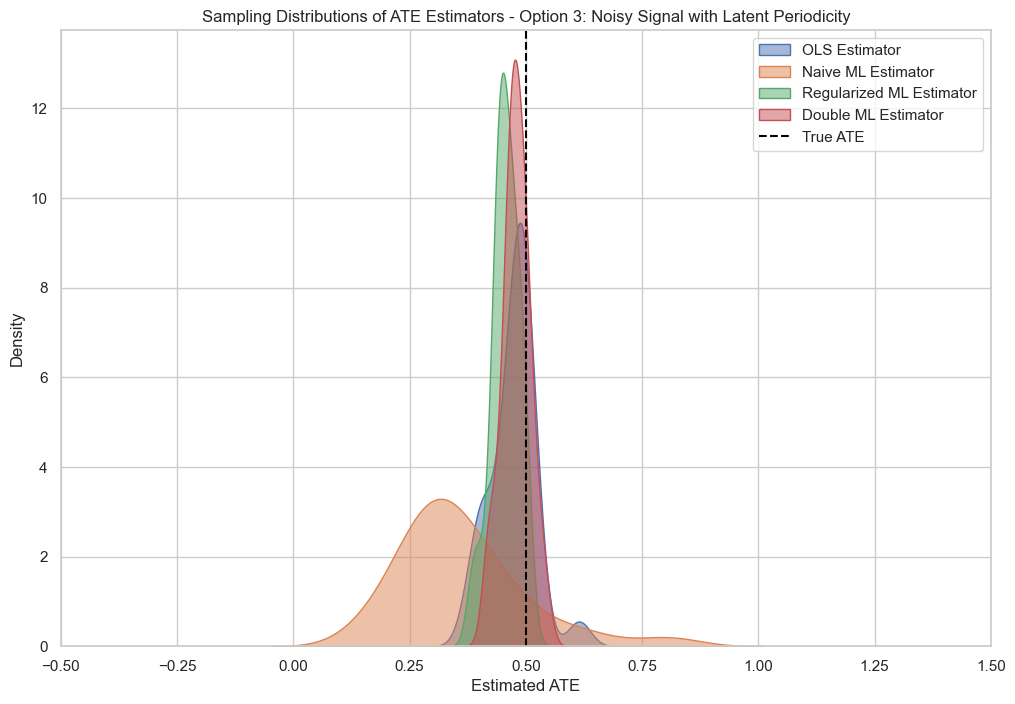


Summary Statistics:
               mean       std      Bias
OLS        0.473147  0.047588 -0.026853
Naive_ML   0.361996  0.135879 -0.138004
Reg_ML     0.455583  0.029293 -0.044417
Double_ML  0.478371  0.029102 -0.021629



Running Simulation for Option 4: Sparse but High Dimensional

Replication 10/30 completed.
Replication 20/30 completed.
Replication 30/30 completed.


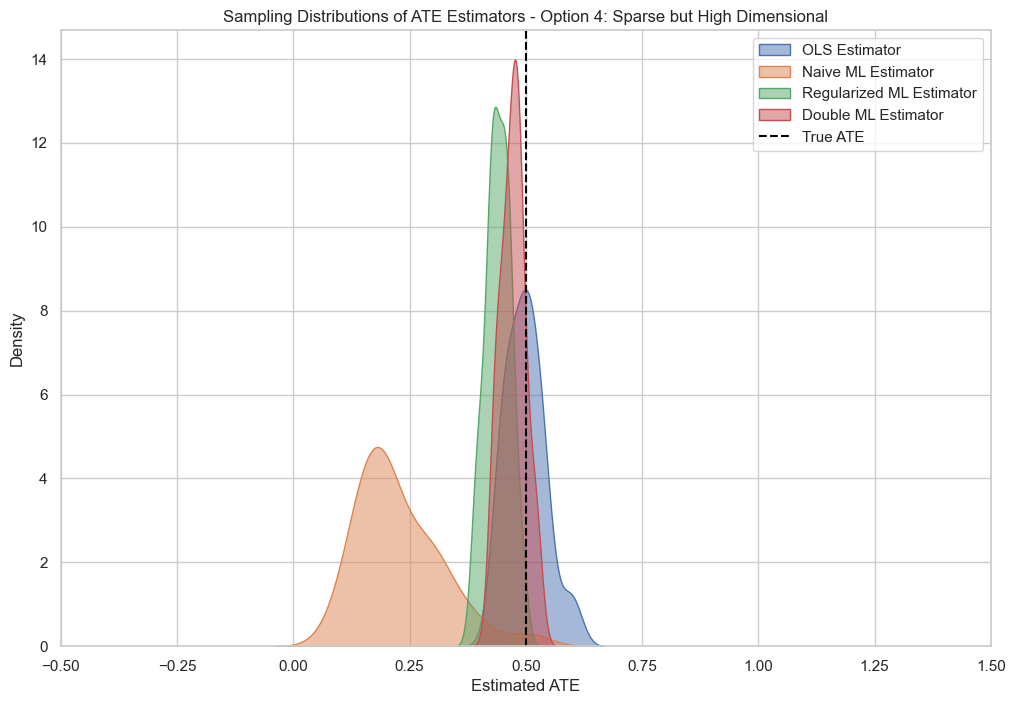


Summary Statistics:
               mean       std      Bias
OLS        0.498380  0.041795 -0.001620
Naive_ML   0.228295  0.090249 -0.271705
Reg_ML     0.439611  0.026022 -0.060389
Double_ML  0.472032  0.026128 -0.027968



Running Simulation for Option 5: Non-Linear Feature Combinations

Replication 10/30 completed.
Replication 20/30 completed.
Replication 30/30 completed.


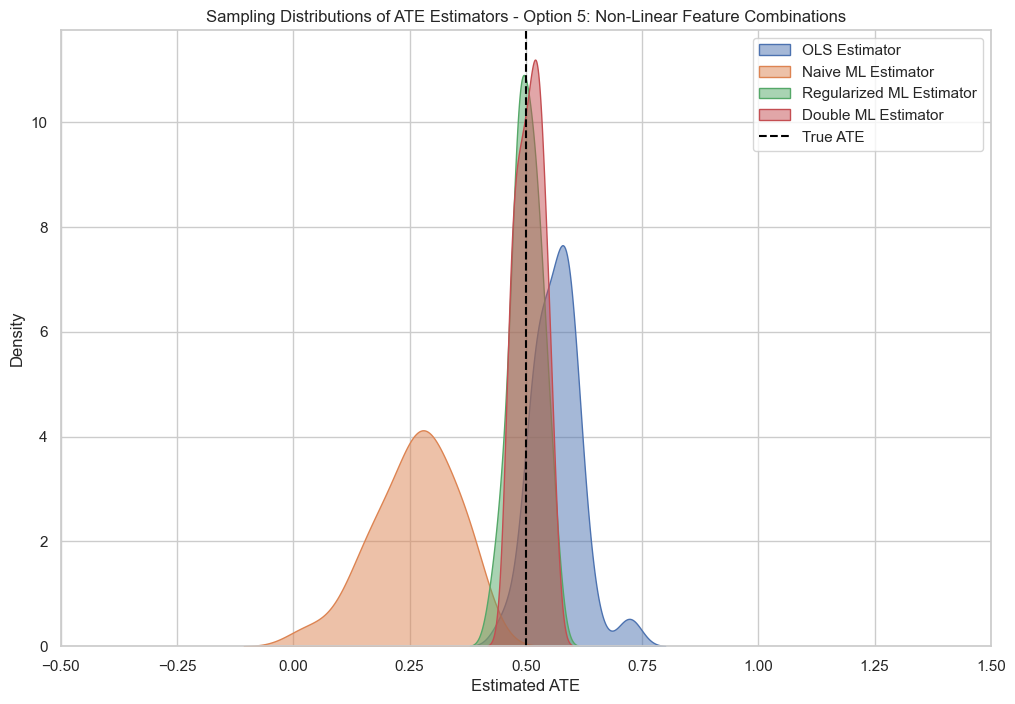


Summary Statistics:
               mean       std      Bias
OLS        0.565565  0.050413  0.065565
Naive_ML   0.260750  0.089021 -0.239250
Reg_ML     0.501754  0.032368  0.001754
Double_ML  0.508682  0.028194  0.008682




In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import KFold
import lightgbm as lgb

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_replications = 30   # Number of simulation replications
n_samples = 1000       # Number of observations per replication
n_features = 500       # Number of covariates (high-dimensional X)
theta_true = 0.5       # True Average Treatment Effect (ATE)

# Function to generate covariance matrix Σ with entries Σ_{kj} = 0.7^{|j-k|}
def generate_covariance_matrix(n_features, rho=0.7):
    indices = np.arange(n_features)
    cov_matrix = rho ** np.abs(np.subtract.outer(indices, indices))
    return cov_matrix

# Define DGP Options
dgps = [
    {
        'name': 'Option 1: Trigonometric and Exponential Terms',
        'm_0': lambda x: np.sin(x[:, 0]) + np.log(np.abs(x[:, 2]) + 1) / (1 + np.exp(-x[:, 1])),
        'g_0': lambda x: np.cos(x[:, 0] * x[:, 1]) + np.exp(-np.abs(x[:, 3])) + x[:, 4]**2 / (1 + np.abs(x[:, 5]))
    },
    {
        'name': 'Option 2: Sparse Interactions with Polynomial Growth',
        'm_0': lambda x: x[:, 0]**2 + 0.5 * x[:, 1]**3 - np.sqrt(np.abs(x[:, 2])) + 0.25 * x[:, 3] * x[:, 4],
        'g_0': lambda x: 0.5 * x[:, 0] * x[:, 1]**2 - np.log(np.abs(x[:, 2]) + 1) + x[:, 3]**3 - 0.25 * x[:, 4]**2 * x[:, 5]
    },
    {
        'name': 'Option 3: Noisy Signal with Latent Periodicity',
        'm_0': lambda x: np.sin(2 * np.pi * x[:, 0]) + np.cos(2 * np.pi * x[:, 1]) + 0.1 * x[:, 2]**2 + np.random.normal(0, 0.1, x.shape[0]),
        'g_0': lambda x: np.cos(x[:, 0] + x[:, 1]) + np.sin(x[:, 2] - x[:, 3]) + np.exp(-np.abs(x[:, 4])) + np.random.normal(0, 0.1, x.shape[0])
    },
    {
        'name': 'Option 4: Sparse but High Dimensional',
        'm_0': lambda x: np.sum([x[:, j] / (1 + np.abs(x[:, j + 5])) for j in range(5)], axis=0) + np.log(1 + np.abs(x[:, 10])),
        'g_0': lambda x: np.sum([np.sin(x[:, j]) / (1 + np.exp(x[:, j + 3])) for j in range(3)], axis=0) + 1 / np.sqrt(np.abs(x[:, 15]) + 1)
    },
    {
        'name': 'Option 5: Non-Linear Feature Combinations',
        'm_0': lambda x: (x[:, 0] * x[:, 1]) / (1 + np.abs(x[:, 2])) + np.exp(-np.abs(x[:, 3])) + np.log(1 + np.abs(x[:, 4])) / (1 + np.abs(x[:, 5])),
        'g_0': lambda x: np.sin(x[:, 0] * x[:, 1]) + np.cos(x[:, 2] - x[:, 3]) + x[:, 4]**2 / (1 + np.exp(x[:, 5]))
    }
]

# Define Estimators
def ols_estimator(y, d, X):
    X_design = np.column_stack((d, X))
    model = LinearRegression().fit(X_design, y)
    theta_hat = model.coef_[0]
    return theta_hat

def naive_ml_estimator(y, d, X):
    # LightGBM without regularization
    lgb_params = {'num_leaves': 31, 'learning_rate': 0.1, 'verbose': -1}
    lgb_y = lgb.LGBMRegressor(**lgb_params)
    lgb_d = lgb.LGBMRegressor(**lgb_params)
    lgb_y.fit(X, y)
    lgb_d.fit(X, d)
    M_y_X = lgb_y.predict(X)
    M_d_X = lgb_d.predict(X)
    y_tilde = y - M_y_X
    d_tilde = d - M_d_X
    # Regress y_tilde on d_tilde
    model = LinearRegression().fit(d_tilde.reshape(-1,1), y_tilde)
    theta_hat = model.coef_[0]
    return theta_hat

def regularized_ml_estimator(y, d, X):
    # LightGBM with regularization
    lgb_params = {'num_leaves': 10, 'learning_rate': 0.1, 'verbose': -1,
                  'min_data_in_leaf': 20, 'max_depth': 5}
    lgb_y = lgb.LGBMRegressor(**lgb_params)
    lgb_d = lgb.LGBMRegressor(**lgb_params)
    lgb_y.fit(X, y)
    lgb_d.fit(X, d)
    M_y_X = lgb_y.predict(X)
    M_d_X = lgb_d.predict(X)
    y_tilde = y - M_y_X
    d_tilde = d - M_d_X
    # Regress y_tilde on d_tilde
    model = LinearRegression().fit(d_tilde.reshape(-1,1), y_tilde)
    theta_hat = model.coef_[0]
    return theta_hat

def double_ml_estimator(y, d, X, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    theta_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        d_train, d_test = d[train_index], d[test_index]
        # Estimate M_y(X) and M_d(X) on training data
        lgb_params = {'num_leaves': 10, 'learning_rate': 0.1, 'verbose': -1,
                      'min_data_in_leaf': 20, 'max_depth': 5}
        lgb_y = lgb.LGBMRegressor(**lgb_params)
        lgb_d = lgb.LGBMRegressor(**lgb_params)
        lgb_y.fit(X_train, y_train)
        lgb_d.fit(X_train, d_train)
        # Predict on test data
        M_y_X = lgb_y.predict(X_test)
        M_d_X = lgb_d.predict(X_test)
        y_tilde = y_test - M_y_X
        d_tilde = d_test - M_d_X
        # Regress y_tilde on d_tilde in test data
        model = LinearRegression().fit(d_tilde.reshape(-1,1), y_tilde)
        theta_hat_fold = model.coef_[0]
        theta_list.append(theta_hat_fold)
    # Average theta estimates over folds
    theta_hat = np.mean(theta_list)
    return theta_hat

# Function to run simulation for a single DGP
def run_simulation(dgp, dgp_index):
    print(f"\n{'='*60}")
    print(f"Running Simulation for {dgp['name']}")
    print(f"{'='*60}\n")
    
    # Initialize storage for estimator results
    results = {
        'OLS': np.empty(n_replications),
        'Naive_ML': np.empty(n_replications),
        'Reg_ML': np.empty(n_replications),
        'Double_ML': np.empty(n_replications)
    }
    
    # Simulation Loop
    for i in range(n_replications):
        # Generate data
        cov_matrix = generate_covariance_matrix(n_features)
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)
        v_i = np.random.normal(0, 1, n_samples)
        zeta_i = np.random.normal(0, 1, n_samples)
        d_i = dgp['m_0'](X) + v_i
        y_i = theta_true * d_i + dgp['g_0'](X) + zeta_i
        
        # Apply Estimators
        results['OLS'][i] = ols_estimator(y_i, d_i, X)
        results['Naive_ML'][i] = naive_ml_estimator(y_i, d_i, X)
        results['Reg_ML'][i] = regularized_ml_estimator(y_i, d_i, X)
        results['Double_ML'][i] = double_ml_estimator(y_i, d_i, X)
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Replication {i+1}/{n_replications} completed.")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Plotting the Sampling Distributions
    plt.figure(figsize=(12, 8))
    sns.kdeplot(results_df['OLS'], label='OLS Estimator', fill=True, alpha=0.5)
    sns.kdeplot(results_df['Naive_ML'], label='Naive ML Estimator', fill=True, alpha=0.5)
    sns.kdeplot(results_df['Reg_ML'], label='Regularized ML Estimator', fill=True, alpha=0.5)
    sns.kdeplot(results_df['Double_ML'], label='Double ML Estimator', fill=True, alpha=0.5)
    plt.axvline(theta_true, color='black', linestyle='--', label='True ATE')
    plt.title(f'Sampling Distributions of ATE Estimators - {dgp["name"]}')
    plt.xlabel('Estimated ATE')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(theta_true - 1, theta_true + 1)
    plt.show()
    
    # Summary Statistics
    summary_stats = results_df.describe().loc[['mean', 'std']].transpose()
    summary_stats['Bias'] = summary_stats['mean'] - theta_true
    print("\nSummary Statistics:")
    print(summary_stats)
    print("\n")

# Run simulations for all DGPs
for idx, dgp in enumerate(dgps):
    run_simulation(dgp, idx+1)
